In [291]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 66

# 各パス指定

In [292]:
dataset = 'model/pose_classifier/squat_pose.csv'
model_save_path = 'model/pose_classifier/squat4_pose_classifier.hdf5'

# 分類数設定

In [293]:
NUM_CLASSES = 3

# 学習データ読み込み

In [294]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (33 * 2) + 1)))

In [295]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [297]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((33 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [298]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_30 (Dropout)        (None, 66)                0         
                                                                 
 dense_45 (Dense)            (None, 20)                1340      
                                                                 
 dropout_31 (Dropout)        (None, 20)                0         
                                                                 
 dense_46 (Dense)            (None, 10)                210       
                                                                 
 dense_47 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,583
Trainable params: 1,583
Non-trainable params: 0
_________________________________________________________________


In [299]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [300]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [301]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/6 [====>.........................] - ETA: 4s - loss: 1.2626 - accuracy: 0.2969
Epoch 1: saving model to model/pose_classifier\squat4_pose_classifier.hdf5
6/6 [==============================] - 1s 48ms/step - loss: 1.1986 - accuracy: 0.3142 - val_loss: 1.0786 - val_accuracy: 0.4351
Epoch 2/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1522 - accuracy: 0.3750
Epoch 2: saving model to model/pose_classifier\squat4_pose_classifier.hdf5
6/6 [==============================] - 0s 12ms/step - loss: 1.1177 - accuracy: 0.4008 - val_loss: 1.0321 - val_accuracy: 0.4937
Epoch 3/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0675 - accuracy: 0.4297
Epoch 3: saving model to model/pose_classifier\squat4_pose_classifier.hdf5
6/6 [==============================] - 0s 11ms/step - loss: 1.0514 - accuracy: 0.4721 - val_loss: 1.0114 - val_accuracy: 0.4435
Epoch 4/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0199 - accuracy: 0.5391
Epoch 4: saving

In [302]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 1.0000


In [303]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [304]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 56ms/step
[4.8707332e-09 2.9333878e-02 9.7066611e-01]
2


# 混同行列

8/8 [==============================] - 0s 1ms/step


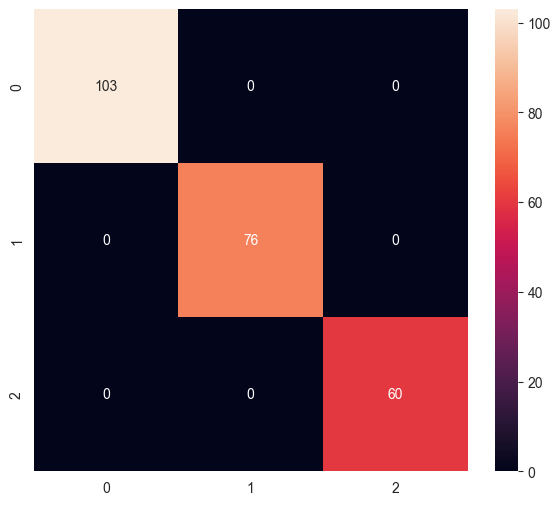

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        60

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239



In [305]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [306]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [307]:
# モデルを変換(量子化)
tflite_save_path = 'model/pose_classifier/squat4_pose_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp_8590gbk\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp_8590gbk\assets


4640

# 推論テスト

In [308]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [309]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [310]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [311]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [312]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.7952270e-09 3.1079909e-02 9.6892011e-01]
2
